# Import Libraries

In [5]:
import numpy as np #type: ignore
import random
from collections import defaultdict
from IPython.display import clear_output #type: ignore
import tensorflow as tf #type: ignore
import os
from sklearn.model_selection import train_test_split #type: ignore
import matplotlib.pyplot as plt #type: ignore

# Connect Four and MCTS Code

In [6]:
def update_board(board_temp,color,column):
    board = board_temp.copy()
    colsum = abs(board[0,column])+abs(board[1,column])+abs(board[2,column])+abs(board[3,column])+abs(board[4,column])+abs(board[5,column])
    row = int(5-colsum)
    if row > -0.5:
        if color == 'plus':
            board[row,column] = 1
        else:
            board[row,column] = -1
    return board
    
def check_for_win_slow(board):
    nrow = board.shape[0]
    ncol = board.shape[1]
    winner = 'nobody'
    for col in range(ncol):
        for row in reversed(range(nrow)):
            if abs(board[row,col]) < 0.1:
                break
            # vertical
            if row <= (nrow-4):
                tempsum = board[row,col]+board[row+1,col]+board[row+2,col]+board[row+3,col]
                if tempsum==4:
                    winner = 'v-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'v-minus'
                    return winner
            # horizontal
            if col <= (ncol-4):
                tempsum = board[row,col]+board[row,col+1]+board[row,col+2]+board[row,col+3]
                if tempsum==4:
                    winner = 'h-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'h-minus'
                    return winner
            # diagonal down-right
            if (row <= (nrow-4)) and (col <= (ncol-4)):
                tempsum = board[row,col]+board[row+1,col+1]+board[row+2,col+2]+board[row+3,col+3]
                if tempsum==4:
                    winner = 'd-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'd-minus'
                    return winner
            # diagonal down-left
            if (row <= (nrow-4)) and (col >= 3):
                tempsum = board[row,col]+board[row+1,col-1]+board[row+2,col-2]+board[row+3,col-3]
                if tempsum==4:
                    winner = 'd-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'd-minus'
                    return winner
    return winner

def check_for_win(board,col):
    nrow = 6
    # figure out what row was just placed
    colsum = abs(board[0,col])+abs(board[1,col])+abs(board[2,col])+abs(board[3,col])+abs(board[4,col])+abs(board[5,col])
    row = int(6-colsum)
    # vertical check
    if row+3<6:
        vert = board[row,col] + board[row+1,col] + board[row+2,col] + board[row+3,col]
        if vert == 4:
            return 'v-plus'
        elif vert == -4:
            return 'v-minus'
    # horizontal checks (there are several)
    # segment 0-3
    if col+3<7:
        hor = board[row,col] + board[row,col+1] + board[row,col+2] + board[row,col+3]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # segment -1..+2
    if col-1>=0 and col+2<7:
        hor = board[row,col-1] + board[row,col] + board[row,col+1] + board[row,col+2]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # segment -2..+1
    if col-2>=0 and col+1<7:
        hor = board[row,col-2] + board[row,col-1] + board[row,col] + board[row,col+1]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # segment -3..0
    if col-3>=0:
        hor = board[row,col-3] + board[row,col-2] + board[row,col-1] + board[row,col]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # diagonals down-right
    if row < 3 and col < 4:
        DR = board[row,col] + board[row+1,col+1] + board[row+2,col+2] + board[row+3,col+3]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-1>=0 and col-1>=0 and row+2<6 and col+2<7:
        DR = board[row-1,col-1] + board[row,col] + board[row+1,col+1] + board[row+2,col+2]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-2>=0 and col-2>=0 and row+1<6 and col+1<7:
        DR = board[row-2,col-2] + board[row-1,col-1] + board[row,col] + board[row+1,col+1]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-3>=0 and col-3>=0:
        DR = board[row-3,col-3] + board[row-2,col-2] + board[row-1,col-1] + board[row,col]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    # diagonals down-left
    if row+3<6 and col-3>=0:
        DL = board[row,col] + board[row+1,col-1] + board[row+2,col-2] + board[row+3,col-3]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-1>=0 and col+1<7 and row+2<6 and col-2>=0:
        DL = board[row-1,col+1] + board[row,col] + board[row+1,col-1] + board[row+2,col-2]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-2>=0 and col+2<7 and row+1<6 and col-1>=0:
        DL = board[row-2,col+2] + board[row-1,col+1] + board[row,col] + board[row+1,col-1]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-3>=0 and col+3<7:
        DL = board[row-3,col+3] + board[row-2,col+2] + board[row-1,col+1] + board[row,col]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    return 'nobody'

def find_legal(board):
    return [i for i in range(7) if abs(board[0,i]) < 0.1]

def look_for_win(board_,color):
    board_ = board_.copy()
    legal = find_legal(board_)
    winner_col = -1
    for m in legal:
        bt = update_board(board_.copy(),color,m)
        wi = check_for_win(bt,m)
        if wi[2:] == color:
            winner_col = m
            break
    return winner_col

def find_all_nonlosers(board,color):
    if color == 'plus':
        opp = 'minus'
    else:
        opp = 'plus'
    legal = find_legal(board)
    poss_boards = [update_board(board,color,l) for l in legal]
    poss_legal = [find_legal(b) for b in poss_boards]
    allowed = []
    for i in range(len(legal)):
        # if the opponent can immediately win after we move in col=legal[i], skip it
        wins = [j for j in poss_legal[i] 
                if check_for_win(update_board(poss_boards[i],opp,j),j) != 'nobody']
        if len(wins) == 0:
            allowed.append(legal[i])
    return allowed

def back_prop(winner,path,color0,md):
    for i, board_tuple in enumerate(path):
        md[board_tuple][0] += 1
        if winner[2] == color0[0]:
            if i % 2 == 1:
                md[board_tuple][1] += 1
            else:
                md[board_tuple][1] -= 1
        elif winner[2] == 'e':
            # tie => no change
            pass
        else:
            if i % 2 == 1:
                md[board_tuple][1] -= 1
            else:
                md[board_tuple][1] += 1

def rollout(board,next_player):
    winner = 'nobody'
    player = next_player
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            return 'tie'
        move = random.choice(legal)
        board = update_board(board,player,move)
        winner = check_for_win(board,move)
        # switch player
        if player == 'plus':
            player = 'minus'
        else:
            player = 'plus'
    return winner
        
def mcts(board_temp,color0,nsteps):
    # Traditional MCTS, plus small improvements:
    board = board_temp.copy()
    # 1. If there's an immediate winning move, use it
    win_col = look_for_win(board,color0)
    if win_col != -1:
        return win_col
    # 2. Look for any moves that avoid an immediate losing position
    legal0 = find_all_nonlosers(board,color0)
    if len(legal0) == 0:
        # if no way to avoid opponent's immediate threat, use all legal moves
        legal0 = find_legal(board)
    
    mcts_dict = {tuple(board.ravel()):[0,0]}
    for _ in range(nsteps):
        color = color0
        winner = 'nobody'
        board_mcts = board.copy()
        path = [tuple(board_mcts.ravel())]
        
        while winner == 'nobody':
            legal = find_legal(board_mcts)
            if len(legal) == 0:
                winner = 'tie'
                back_prop(winner,path,color0,mcts_dict)
                break
            # list of next possible boards
            board_list = []
            for col in legal:
                b_next = update_board(board_mcts,color,col)
                board_list.append(tuple(b_next.ravel()))
                if tuple(b_next.ravel()) not in mcts_dict:
                    mcts_dict[tuple(b_next.ravel())] = [0,0]
            
            # UCB1 
            ucb1 = np.zeros(len(legal))
            for i, bl in enumerate(board_list):
                num_sims, total_value = mcts_dict[bl]
                if num_sims == 0:
                    # large priority for unvisited
                    ucb1[i] = 10 * nsteps
                else:
                    parent_sims = mcts_dict[path[-1]][0]
                    avg_val = total_value / num_sims
                    explore = np.sqrt(np.log(parent_sims)/num_sims)
                    ucb1[i] = avg_val + 2*explore
            
            chosen = np.argmax(ucb1)
            board_mcts = update_board(board_mcts,color,legal[chosen])
            path.append(tuple(board_mcts.ravel()))
            # check winner
            winner = check_for_win(board_mcts,legal[chosen])
            if winner[2] == color[0]:
                back_prop(winner,path,color0,mcts_dict)
                break
            
            # switch player
            color = 'minus' if (color=='plus') else 'plus'
            
            # if the new board has never been visited, do a rollout
            if mcts_dict[tuple(board_mcts.ravel())][0] == 0:
                winner_roll = rollout(board_mcts,color)
                back_prop(winner_roll,path,color0,mcts_dict)
                break
    
    # pick the move with best average reward
    best_col = -1
    max_score = -np.inf
    for col in legal0:
        new_board = tuple(update_board(board,color0,col).ravel())
        num_sims, total_val = mcts_dict[new_board]
        if num_sims == 0:
            # means we never visited it
            score = -np.inf
        else:
            score = total_val/num_sims
        if score > max_score:
            max_score = score
            best_col = col

    return best_col


def board_to_6x7x2(board_2d):
    """
    Convert a 6x7 board with +1, -1, 0 
    into a 6x7x2 one-hot style representation:
       channel 0 => +1 positions
       channel 1 => -1 positions
    """
    X = np.zeros((6,7,2), dtype=np.float32)
    for i in range(6):
        for j in range(7):
            if board_2d[i,j] == 1:
                X[i,j,0] = 1
            elif board_2d[i,j] == -1:
                X[i,j,1] = 1
    return X

def minus_to_plus(board_6x7x2):
    """
    Flip a (6,7,2) board from 'minus perspective' to 'plus perspective'
    by swapping channels 0 and 1.
      channel 0 => +1 squares
      channel 1 => -1 squares
    If originally channel 1 was the 'minus' squares, 
    after swap, that becomes the 'plus' squares, etc.
    """
    flipped = board_6x7x2.copy()
    flipped[..., 0], flipped[..., 1] = board_6x7x2[..., 1], board_6x7x2[..., 0]
    return flipped

def add_symmetric_flips(board_6x7x2, best_move):
    """
    Given a (6,7,2) board and an integer best_move in [0..6],
    return a list of:
      [(original_board_6x7x2, best_move),
       (flipped_board_6x7x2, flipped_move)].
    The flipped version is mirrored left-to-right (column j -> 6-j).
    """
    out = []
    
    # 1) Original
    out.append((board_6x7x2, best_move))
    
    # 2) Flipped left-right
    flipped_board = board_6x7x2[:, ::-1, :].copy()
    flipped_col = 6 - best_move
    out.append((flipped_board, flipped_col))
    
    return out


# Building the Dataset

In [7]:
def play_one_game(
    plus_mcts_steps=800, 
    minus_mcts_steps=800,
    random_openings=2
):
    """
    Play one full game between plus & minus, each side using MCTS.
    - random_openings => number of random moves each side does at the start.
    - We'll capture BOTH plus and minus moves. 
      For minus, we flip the board to plus perspective before storing.
    - We do NOT store random moves. 
    - Return a list of (board_6x7x2, best_move_col) for all MCTS-chosen moves 
      from the plus perspective.
    """
    data_this_game = []
    board = np.zeros((6,7), dtype=np.float32)
    winner = 'nobody'
    player = 'plus'
    move_count = 0
    
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            break  # tie

        # Possibly do a random move in the opening
        use_random = False
        if move_count < 2*random_openings:
            # e.g. first X moves in the entire game: random for plus & minus
            use_random = True

        if use_random:
            col = random.choice(legal)
        else:
            # MCTS to pick best move
            if player == 'plus':
                col = mcts(board, 'plus', plus_mcts_steps)
            else:
                col = mcts(board, 'minus', minus_mcts_steps)

        old_board = board.copy()  # board before the current move
        board = update_board(board, player, col)
        winner = check_for_win(board, col)

        # Store the data if this move is MCTS-based (not random)
        if not use_random:
            if player == 'plus':
                # plus perspective => straightforward
                board_6x7x2 = board_to_6x7x2(old_board)
                data_this_game.append((board_6x7x2, col))
            else:
                # minus perspective => flip channels to get plus perspective
                board_6x7x2_minus = board_to_6x7x2(old_board)
                board_6x7x2_plus = minus_to_plus(board_6x7x2_minus)
                # The chosen column from minus's vantage is the same col index on the grid
                data_this_game.append((board_6x7x2_plus, col))

        # Switch player
        player = 'minus' if (player == 'plus') else 'plus'
        move_count += 1
    
    return data_this_game

def build_dataset(
    num_games=10000,
    plus_mcts_steps=2000,
    minus_mcts_steps=1500,
    random_openings=3
):
    """
    Build a large dataset:
      - num_games = 10,000
      - plus_mcts_steps = 2000
      - minus_mcts_steps = 1500
      - random_openings = 3 (first 3 moves by each side are random, not stored)

    For each (board, best_move) from play_one_game, we also 
    add a horizontally flipped version. 
    Then we deduplicate collisions by taking the most frequent best_move 
    for each board.
    
    Returns final X, y as numpy arrays:
       X.shape = (N, 6, 7, 2)
       y.shape = (N,)
    """
    data_dict = defaultdict(lambda: defaultdict(int))
    
    for g in range(num_games):
        if g % 100 == 0:
            print(f"Playing game {g} / {num_games} ...")
        game_data = play_one_game(
            plus_mcts_steps=plus_mcts_steps,
            minus_mcts_steps=minus_mcts_steps,
            random_openings=random_openings
        )
        # For each board, also add symmetrical flip
        for (board_6x7x2, best_move) in game_data:
            augmented = add_symmetric_flips(board_6x7x2, best_move)
            for (b_aug, m_aug) in augmented:
                key = b_aug.tobytes()
                data_dict[key][m_aug] += 1
    
    # Resolve collisions
    X_list = []
    y_list = []
    for key, move_counts in data_dict.items():
        # pick the move with highest count
        best_move = max(move_counts, key=move_counts.get)
        arr = np.frombuffer(key, dtype=np.float32).reshape(6,7,2)
        X_list.append(arr)
        y_list.append(best_move)
    
    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int32)
    
    return X, y

In [8]:
if __name__ == "__main__":
    X, y = build_dataset(
        num_games=10000,       
        plus_mcts_steps=2000,  
        minus_mcts_steps=1500, 
        random_openings=3      
    )
    print("Dataset built:")
    print("X shape:", X.shape)  # (N, 6, 7, 2)
    print("y shape:", y.shape)  # (N,)
    unique_cols = np.unique(y)
    print("Unique moves in y:", unique_cols)  # Should be [0..6]

Playing game 0 / 3000 ...
Playing game 50 / 3000 ...
Playing game 100 / 3000 ...
Playing game 150 / 3000 ...
Playing game 200 / 3000 ...
Playing game 250 / 3000 ...
Playing game 300 / 3000 ...
Playing game 350 / 3000 ...
Playing game 400 / 3000 ...
Playing game 450 / 3000 ...
Playing game 500 / 3000 ...
Playing game 550 / 3000 ...
Playing game 600 / 3000 ...
Playing game 650 / 3000 ...
Playing game 700 / 3000 ...
Playing game 750 / 3000 ...
Playing game 800 / 3000 ...
Playing game 850 / 3000 ...
Playing game 900 / 3000 ...
Playing game 950 / 3000 ...
Playing game 1000 / 3000 ...
Playing game 1050 / 3000 ...
Playing game 1100 / 3000 ...
Playing game 1150 / 3000 ...
Playing game 1200 / 3000 ...
Playing game 1250 / 3000 ...
Playing game 1300 / 3000 ...
Playing game 1350 / 3000 ...
Playing game 1400 / 3000 ...
Playing game 1450 / 3000 ...
Playing game 1500 / 3000 ...
Playing game 1550 / 3000 ...
Playing game 1600 / 3000 ...
Playing game 1650 / 3000 ...
Playing game 1700 / 3000 ...
Playing 

In [10]:
# Saving to disk:
np.save("X_dataset.npy", X)
np.save("y_dataset.npy", y)

# Training the CNN

In [18]:
X_file = "X_dataset.npy"
y_file = "y_dataset.npy"

X = np.load(X_file)  # shape (N, 6, 7, 2)
y = np.load(y_file)  # shape (N,)

print("Data shapes:")
print("X:", X.shape)
print("y:", y.shape)
unique_moves = np.unique(y)
print("Unique moves in y:", unique_moves)  # should be [0..6]

Data shapes:
X: (33203, 6, 7, 2)
y: (33203,)
Unique moves in y: [0 1 2 3 4 5 6]


In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=22, 
    shuffle=True
)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])

Training set size: 26562
Validation set size: 6641


In [20]:
print("\nAvailable GPUs:", tf.config.list_physical_devices('GPU'))


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
model = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(6,7,2)),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.ReLU(), 
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),  # (6,7) -> (3,4)

    # Block 2
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),  # (3,4) -> (1,2)

    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # Flatten
    tf.keras.layers.Flatten(),

    # Dense block
    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),

    # Output
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 6, 7, 64)          1216      
                                                                 
 batch_normalization (BatchN  (None, 6, 7, 64)         256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 6, 7, 64)          0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 batch_normalization_1 (Batc  (None, 3, 3, 128)       

In [22]:
epochs = 50
batch_size = 32

# Optional: Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],   # remove to get rid of early stopping
    verbose=1
)

Epoch 1/50
831/831 [==============================] - 5s 5ms/step - loss: 2.1686 - accuracy: 0.1947 - val_loss: 1.8720 - val_accuracy: 0.2561
Epoch 2/50
831/831 [==============================] - 4s 4ms/step - loss: 1.9903 - accuracy: 0.2291 - val_loss: 1.8194 - val_accuracy: 0.2804
Epoch 3/50
831/831 [==============================] - 4s 4ms/step - loss: 1.9013 - accuracy: 0.2620 - val_loss: 1.7712 - val_accuracy: 0.3108
Epoch 4/50
831/831 [==============================] - 4s 4ms/step - loss: 1.8371 - accuracy: 0.2871 - val_loss: 1.7346 - val_accuracy: 0.3305
Epoch 5/50
831/831 [==============================] - 4s 4ms/step - loss: 1.7771 - accuracy: 0.3187 - val_loss: 1.7034 - val_accuracy: 0.3451
Epoch 6/50
831/831 [==============================] - 4s 4ms/step - loss: 1.7303 - accuracy: 0.3366 - val_loss: 1.6782 - val_accuracy: 0.3579
Epoch 7/50
831/831 [==============================] - 4s 4ms/step - loss: 1.6822 - accuracy: 0.3598 - val_loss: 1.6383 - val_accuracy: 0.3715
Epoch 

In [26]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc*100:.2f}%   (loss={val_loss:.4f})")

Validation accuracy: 41.47%   (loss=1.5674)


In [24]:
#model.save("cnn_connect4.h5")
#print("Model saved to cnn_connect4.h5.")

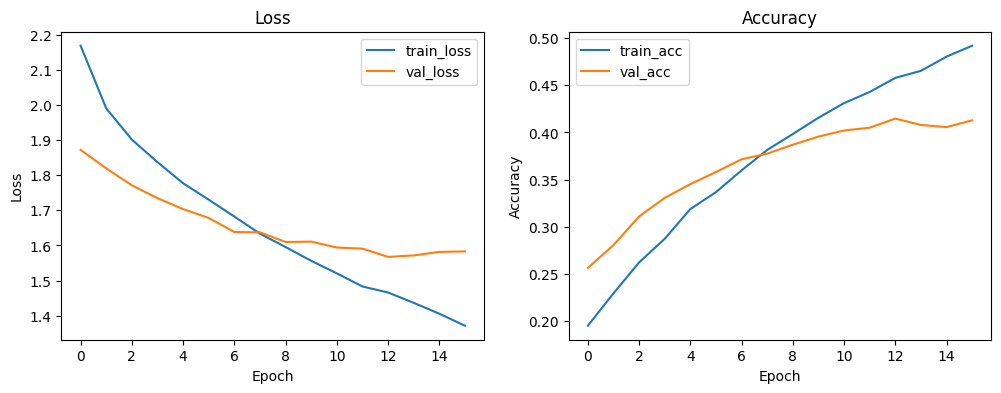

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
axs[0].plot(history.history['loss'], label='train_loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot accuracy
axs[1].plot(history.history['accuracy'], label='train_acc')
axs[1].plot(history.history['val_accuracy'], label='val_acc')
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()